## U-Net Segmentation

## U-Net Architecture

- **PapeLink:** https://arxiv.org/abs/1505.04597
- **Dataset:** https://www.kaggle.com/competitions/data-science

![Unet](images/unet.png)

In [1]:
# Supress warnings

import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import tensorflow as tf
from skimage.io import imread, imshow
from skimage.transform import resize

In [4]:
## define seed -> after multiple execution it gives the same output
seed = 42
np.random.seed = seed

In [5]:
# Image shape

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


In [6]:
# Train and test path 
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'


In [7]:
# get list of all subfolders

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


In [8]:
print(len(train_ids))
print(len(test_ids))

670
65


In [9]:
# define placeholders (also used to replace NaN in images to resize by 0)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)


In [10]:
print('Resizing training images and masks \n')


# Loop through all train_ids
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    
    # Get the path to the image and mask directories
    path = TRAIN_PATH + id_
    
    # Read the image and keep the first IMG_CHANNELS channels
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  # (number of test images, height, width, channels)
    
    # Resize the image to IMG_HEIGHT x IMG_WIDTH while keeping the pixel values (mode='constant')
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # Store the processed image into the X_train array at index n
    X_train[n] = img  #Fill empty X_train with values from img
    
    # Initialize an empty mask of dimensions IMG_HEIGHT x IMG_WIDTH x 1 with boolean values
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    
    # Loop through each file in the masks directory
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        
        # Read the mask file
        mask_ = imread(path + '/masks/' + mask_file)
        
        # Resize the mask to IMG_HEIGHT x IMG_WIDTH while keeping the pixel values (mode='constant'), and add an extra dimension
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        
        # Merge all the masks associated with the same image by taking the maximum value at each pixel location
        mask = np.maximum(mask, mask_)  
    
    # Store the processed mask into the Y_train array at index n
    Y_train[n] = mask   
    

    

# test images
# Create an empty array for test images with dimensions as (number of test images, height, width, channels)
# The datatype for the array is uint8 which can hold values from 0 to 255

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Initialize an empty list to store the original sizes of the test images
sizes_test = []
print('Resizing test images') 

# Loop through all the test_ids
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    # Get the path to the test image
    path = TEST_PATH + id_
    
    # Read the image and keep the first IMG_CHANNELS channels
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    # Append the original size of the image to sizes_test list
    sizes_test.append([img.shape[0], img.shape[1]])
    
    # Resize the image to IMG_HEIGHT x IMG_WIDTH while keeping the pixel values
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # Store the processed image into the X_test array at index n
    X_test[n] = img

print('Done!')

Resizing training images and masks 



100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [06:52<00:00,  1.62it/s]


Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 36.03it/s]

Done!


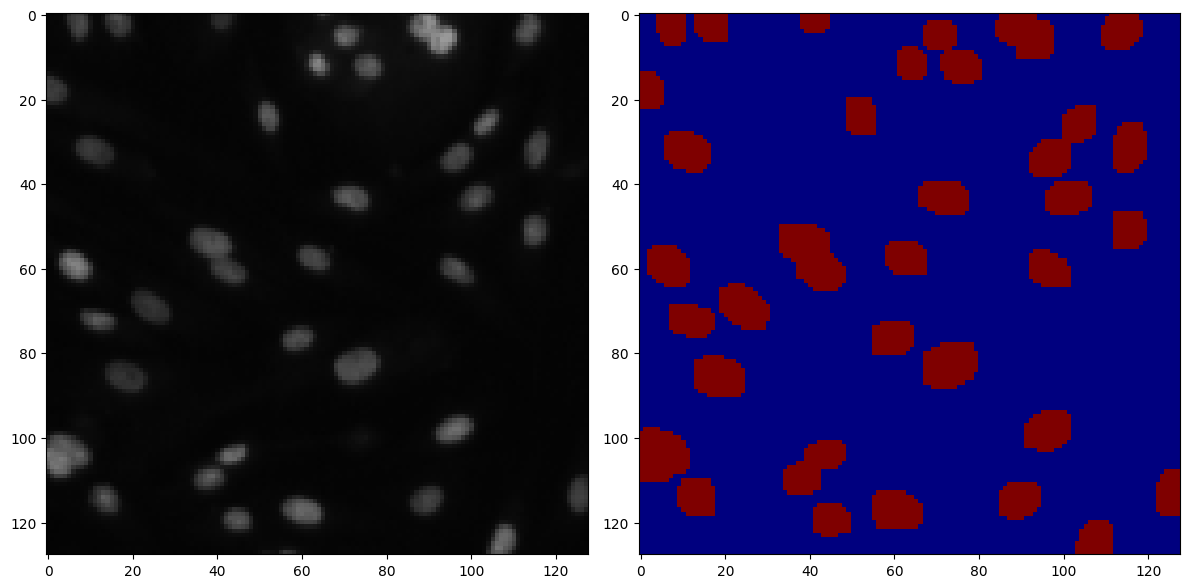

In [25]:
## Check random image - sanity check
image_x = random.randint(0, len(train_ids))

plt.figure(figsize=(12, 6))
plt.subplot(121)
imshow(X_train[image_x])

plt.subplot(122)
imshow(np.squeeze(Y_train[image_x]), cmap='jet')
plt.show()

# Check documentation for 
1. kernal_initializer: https://keras.io/api/layers/initializers/

2. Activation Function: https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

3. Further more about(padding, stride, input, kernal_size): https://poloclub.github.io/cnn-explainer/

## Build the model

In [26]:
# Inputs
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Normalization
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# Output Layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

# Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])


In [27]:
# Complication
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [28]:
# Summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

 dropout_25 (Dropout)           (None, 64, 64, 32)   0           ['conv2d_52[0][0]']              
                                                                                                  
 conv2d_53 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_25[0][0]']             
                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 128, 128, 16  2064       ['conv2d_53[0][0]']              
 nspose)                        )                                                                 
                                                                                                  
 concatenate_11 (Concatenate)   (None, 128, 128, 32  0           ['conv2d_transpose_11[0][0]',    
                                )                                 'conv2d_39[0][0]']              
                                                                                                  
 conv2d_54

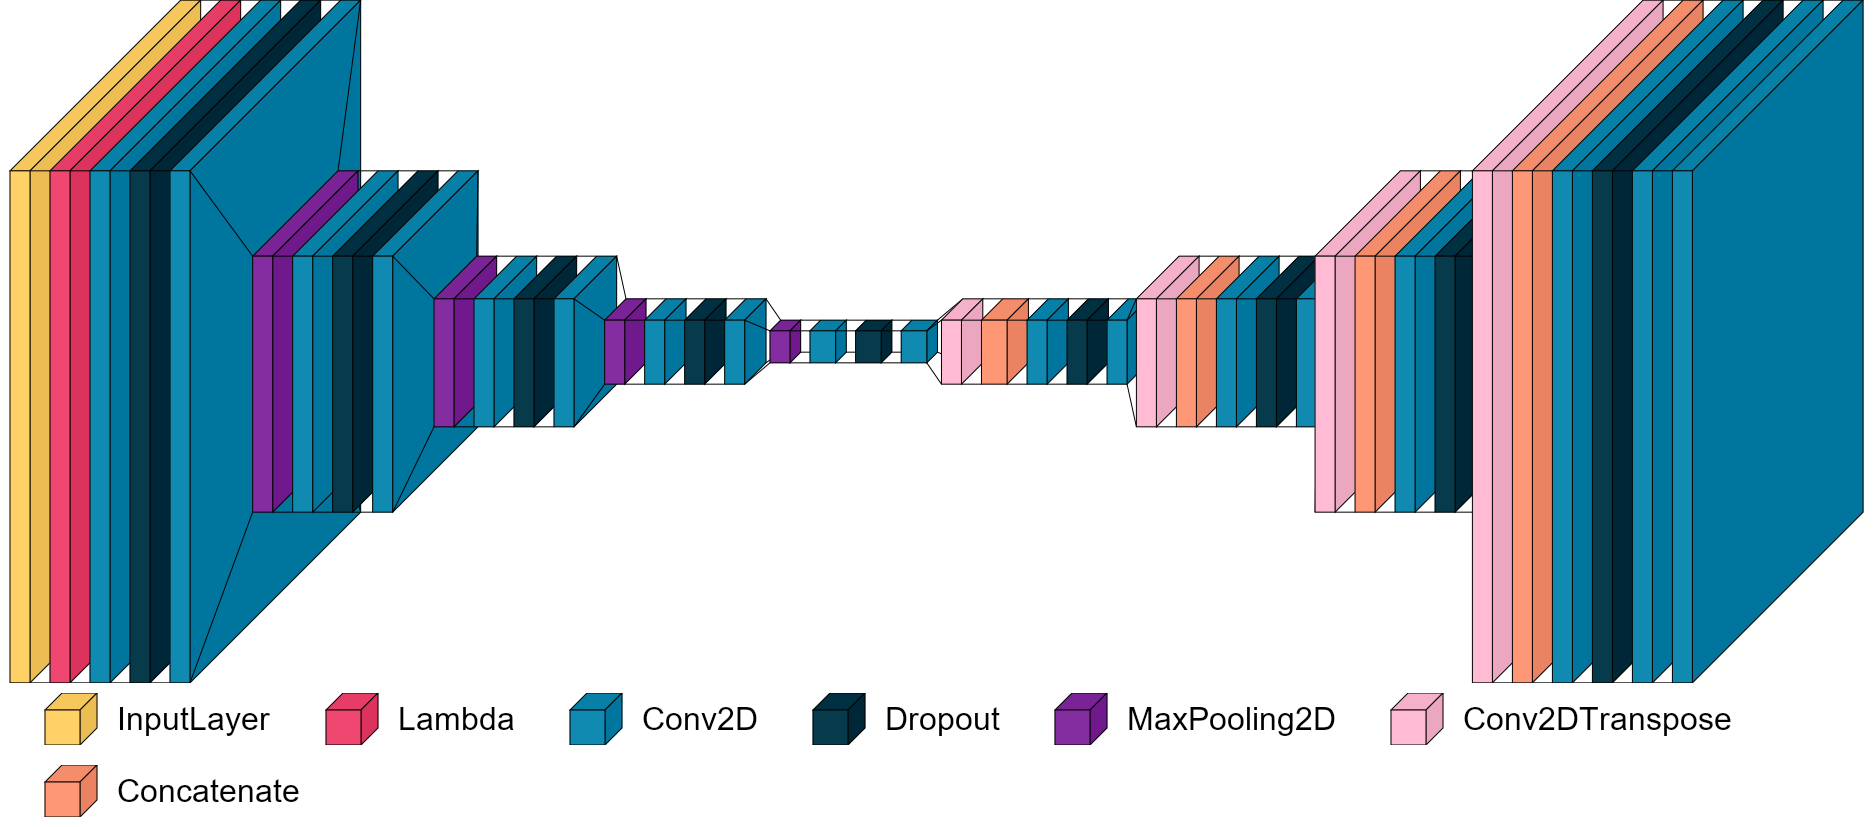

In [29]:
# Visual model
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font, spacing = 20)


In [30]:
#Modelcheckpoint
# import tensorflow_addons as tfa

# tqdm_callback = tfa.callbacks.TQDMProgressBar()
# callbacks=[callbacks,tqdm_callback]

checkpointer = tf.keras.callbacks.ModelCheckpoint('./models/model_for_nuclei.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
            ]


In [31]:
results = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.1, 
                    batch_size=16, 
                    epochs=50, 
                    callbacks=[callbacks])


Epoch 1/50
38/38 [==============================] - 17s 126ms/step - loss: 0.5003 - accuracy: 0.7465 - val_loss: 0.2630 - val_accuracy: 0.8303
Epoch 2/50
38/38 [==============================] - 2s 64ms/step - loss: 0.2576 - accuracy: 0.8948 - val_loss: 0.1653 - val_accuracy: 0.9311
Epoch 3/50
38/38 [==============================] - 2s 64ms/step - loss: 0.1677 - accuracy: 0.9355 - val_loss: 0.1381 - val_accuracy: 0.9422
Epoch 4/50
38/38 [==============================] - 2s 64ms/step - loss: 0.1402 - accuracy: 0.9458 - val_loss: 0.1277 - val_accuracy: 0.9505
Epoch 5/50
38/38 [==============================] - 2s 64ms/step - loss: 0.1314 - accuracy: 0.9508 - val_loss: 0.1149 - val_accuracy: 0.9534
Epoch 6/50
38/38 [==============================] - 2s 64ms/step - loss: 0.1234 - accuracy: 0.9531 - val_loss: 0.1175 - val_accuracy: 0.9554
Epoch 7/50
38/38 [==============================] - 2s 64ms/step - loss: 0.1219 - accuracy: 0.9539 - val_loss: 0.1112 - val_accuracy: 0.9573
Epoch 8/50


In [32]:
results.history

{'loss': [0.5003356337547302,
  0.2576049864292145,
  0.16772934794425964,
  0.14017973840236664,
  0.13140849769115448,
  0.12343486398458481,
  0.12186243385076523,
  0.11515815556049347,
  0.10856109857559204,
  0.10602370649576187,
  0.10439760237932205,
  0.10295283049345016,
  0.0996519923210144,
  0.0970606654882431,
  0.09590301662683487,
  0.09528151154518127,
  0.09521476924419403,
  0.09362775087356567,
  0.09273137152194977],
 'accuracy': [0.7464547753334045,
  0.8948022127151489,
  0.9355087280273438,
  0.9458402395248413,
  0.950801432132721,
  0.9530504941940308,
  0.9538562893867493,
  0.9565840363502502,
  0.9591932892799377,
  0.9600340127944946,
  0.9604937434196472,
  0.9609791040420532,
  0.9619620442390442,
  0.9628159999847412,
  0.9631933569908142,
  0.9636319279670715,
  0.9633493423461914,
  0.9640573859214783,
  0.9641140699386597],
 'val_loss': [0.2630423605442047,
  0.16533613204956055,
  0.13808083534240723,
  0.12772928178310394,
  0.11493980139493942,
  

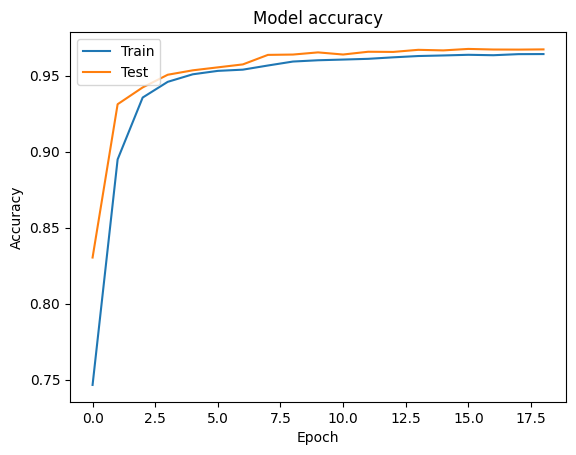

In [33]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

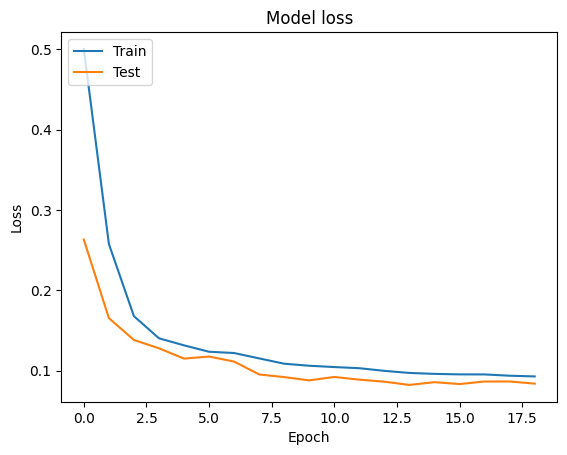

In [34]:
# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
model.save("./models/model_for_nuclei.keras")

## Predictions

In [36]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


3/3 [==============================] - 1s 242ms/step


In [42]:
# Function to display images
def display_images(image):
    plt.imshow(image)
    plt.axis('off')
#     plt.show()

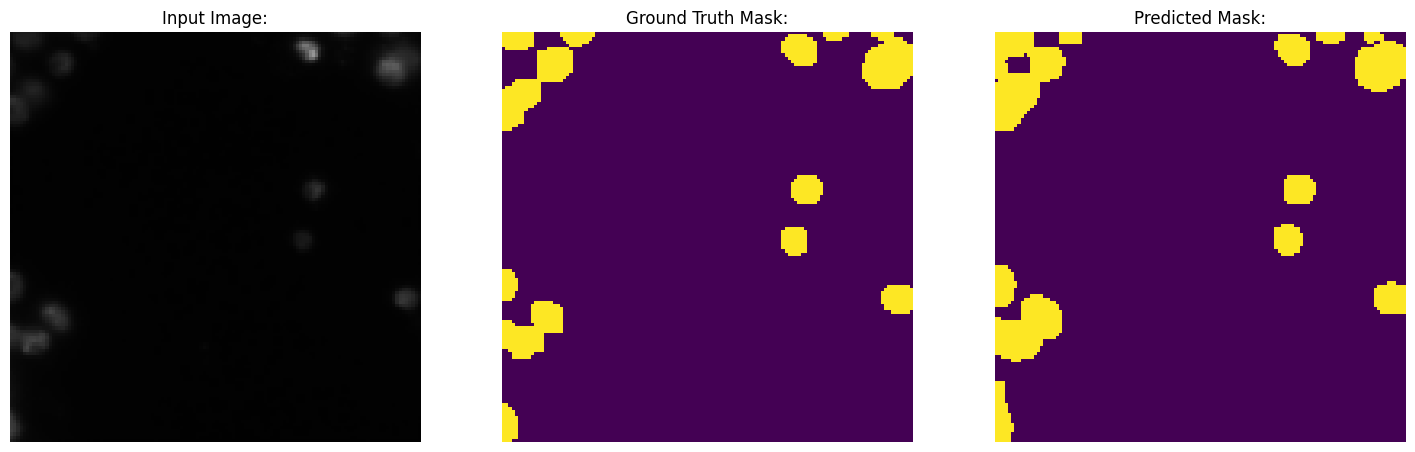

In [49]:
# Select a random index from training set
ix = random.randint(0, len(preds_train_t))

plt.figure(figsize=(18, 6))
plt.subplot(131)
# Display the input image
plt.title("Input Image:")
display_images(X_train[ix])

plt.subplot(132)
# Display the ground truth mask
plt.title("Ground Truth Mask:")
display_images(np.squeeze(Y_train[ix]))

plt.subplot(133)
# Display the predicted mask
plt.title("Predicted Mask:")
display_images(np.squeeze(preds_train_t[ix]))

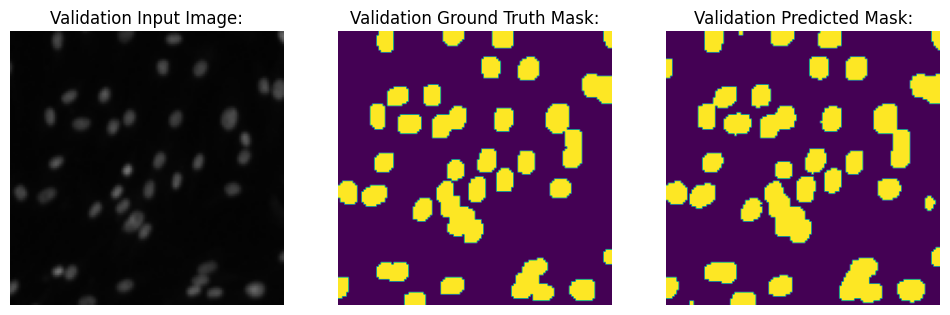

In [50]:
# Select a random index from validation set
ix = random.randint(0, len(preds_val_t))


# Calculate the index from where validation data starts
val_data_start = int(X_train.shape[0] * 0.9)

plt.figure(figsize=(12, 6))
plt.subplot(131)

# Display the validation input image
plt.title("Validation Input Image:")
display_images(X_train[val_data_start:][ix])

plt.subplot(132)
# Display the validation ground truth mask
plt.title("Validation Ground Truth Mask:")
display_images(np.squeeze(Y_train[val_data_start:][ix]))

plt.subplot(133)
# Display the validation predicted mask
plt.title("Validation Predicted Mask:")
display_images(np.squeeze(preds_val_t[ix]))

# Optiional

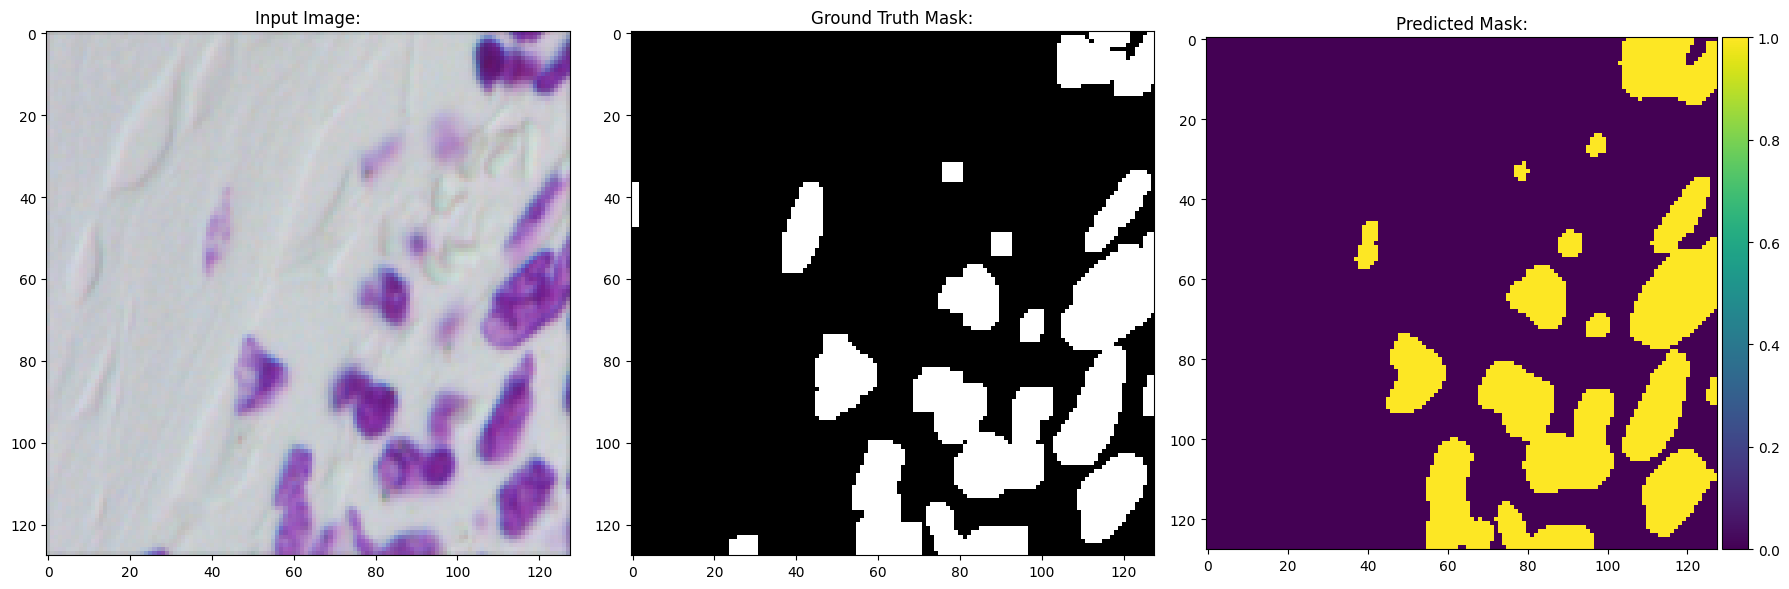

In [55]:
# Optional

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))

plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.title("Input Image:")
imshow(X_train[ix])


plt.subplot(132)
plt.title("Ground Truth Mask:")
imshow(np.squeeze(Y_train[ix]))

plt.subplot(133)
plt.title("Predicted Mask:")
imshow(np.squeeze(preds_train_t[ix]))
plt.show()



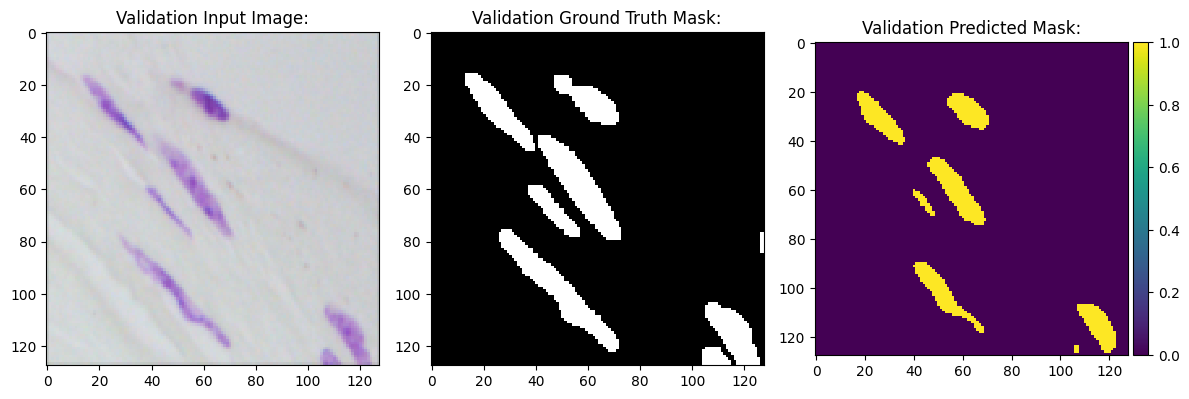

In [62]:
# Optional

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))

plt.figure(figsize=(12, 6))
plt.subplot(131)
# Display the validation input image
plt.title("Validation Input Image:")
imshow(X_train[int(X_train.shape[0]*0.9):][ix])


plt.subplot(132)
# Display the validation ground truth mask
plt.title("Validation Ground Truth Mask:")
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))


plt.subplot(133)
# Display the validation predicted mask
plt.title("Validation Predicted Mask:")
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
